In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from calendar import month_name,month_abbr
DIR = './processed/'

In [2]:
# read OSI-SAF 450 CDR SIE and calculate climatology
osi450_sie = pd.read_csv(DIR+'OSI-450-CDR_SIE_m_1979-2014.csv',index_col=0,parse_dates=True)
osi450_sie_clim = osi450_sie.groupby(osi450_sie.index.month).mean()

In [3]:
# read CMIP6 SIE and calculate climatology over Earth Obs period
sie = pd.read_csv(DIR+'CMIP6-26_SIE_m_18500115-20141215.csv',index_col=0,parse_dates=True)
# earth observation period
eo = sie['1979':'2014']
eo_clim = eo.groupby(eo.index.month).mean()

In [5]:
# pip3 install SkillMetrics (if not installed, open a terminal from the launcher and run this cmd)
import skill_metrics as sm

In [6]:
# reference seasonal cycle from satellite data
ref = osi450_sie_clim.values.squeeze()

# Calculate statistics for target diagram
# mean bias, central and full RMSD (in units of million km2)
bias = []
crmsd = []
rmsd = []
for m in eo_clim.columns:
    target_stats = sm.target_statistics(eo_clim[m],ref,'data')
    # Store statistics in lists (quicker)
    bias.append(target_stats['bias'])
    crmsd.append(target_stats['crmsd'])
    rmsd.append(target_stats['rmsd'])
# convert to arrays
bias = np.array(bias)
crmsd = np.array(crmsd)
rmsd = np.array(rmsd)

In [7]:
# rank models according to RMSD and create a dataframe
#isort= np.argsort(np.abs(bias))
isort = np.argsort(rmsd)

# sort model names according to the ranking
labels = np.array(eo_clim.columns)
lsort = [labels[i] for i in isort]

sie_stats = pd.DataFrame(columns=['source_id','bias','crmsd','rmsd'])
sie_stats['source_id'] = lsort
sie_stats['bias'] = bias[isort]
sie_stats['crmsd'] = crmsd[isort]
sie_stats['rmsd'] = rmsd[isort]
sie_stats

,source_id,bias,crmsd,rmsd
0,FIO-ESM-2-0,-0.320011,1.275416,1.314950
1,IPSL-CM6A-LR-INCA,0.578094,1.258208,1.384659
2,TaiESM1,-0.444978,1.408051,1.476690
3,IPSL-CM6A-LR,0.782396,1.379866,1.586245
4,CMCC-CM2-HR4,0.790556,1.509723,1.704184
5,ACCESS-ESM1-5,-1.252754,1.168421,1.713067
6,GFDL-ESM4,-1.439969,1.426252,2.026748
7,CanESM5,1.715692,1.084501,2.029714
8,MRI-ESM2-0,2.114281,1.069741,2.369499
9,ACCESS-CM2,-2.673610,0.807539,2.792903


In [8]:
best8 = sie_stats.iloc[:8]
#best8.sort_values(by = 'rmsd') # already sorted
best8 = list(best8['source_id'].values)
best8

['FIO-ESM-2-0',
 'IPSL-CM6A-LR-INCA',
 'TaiESM1',
 'IPSL-CM6A-LR',
 'CMCC-CM2-HR4',
 'ACCESS-ESM1-5',
 'GFDL-ESM4',
 'CanESM5']

In [9]:
others = sie_stats.iloc[8:]
others = list(others['source_id'].values)
others

['MRI-ESM2-0',
 'ACCESS-CM2',
 'CMCC-ESM2',
 'SAM0-UNICON',
 'CMCC-CM2-SR5',
 'NorCPM1',
 'IPSL-CM5A2-INCA',
 'NorESM2-MM',
 'MPI-ESM1-2-HR',
 'NorESM2-LM',
 'EC-Earth3-Veg-LR',
 'MPI-ESM1-2-LR',
 'EC-Earth3-AerChem',
 'EC-Earth3',
 'MPI-ESM-1-2-HAM',
 'EC-Earth3-CC',
 'MIROC6',
 'CAS-ESM2-0']

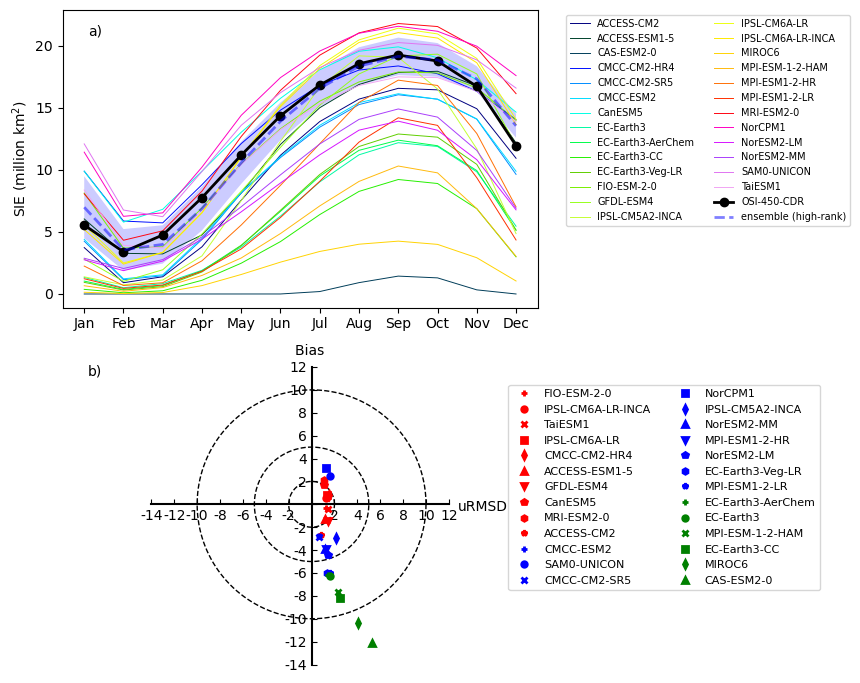

In [46]:
mb8_clim = eo_clim[best8].mean(axis=1)
stdb8_clim = eo_clim[best8].std(axis=1)

fig,axs = plt.subplots(2,1,figsize=(10,8.5))

########### plot the seasonal climatology for CMIP, satellite, and best8 ensemble
ax = axs[0]
# these commands change the color cycler to have as many colors as in the chosen colormap
colormap = plt.cm.gist_ncar
ax.set_prop_cycle(plt.cycler('color', colormap(np.linspace(0, 1, 28))))

eo_clim.plot(ax=ax,linewidth=0.7)
ax.plot(np.arange(1,13),osi450_sie_clim.values,'-ko',linewidth=2,label='OSI-450-CDR')

mb8_clim.plot(ax=ax,color='blue',linewidth=2, linestyle='--', alpha=0.5,label='ensemble (high-rank)')
ax.fill_between(mb8_clim.index, mb8_clim+stdb8_clim, mb8_clim-stdb8_clim, facecolor='blue', alpha=0.2)

ax.legend(bbox_to_anchor=(1.05, 1.0),  fontsize=7, ncol = 2)
ax.set_ylabel('SIE (million km$^2$)')
ax.set_xticks(np.arange(1,13),month_abbr[1:])

########### plot the target diagram
plt.axes(axs[1])
sm.target_diagram(bias[isort],crmsd[isort],rmsd[isort], markerLabel = lsort, markerSize = 4, equalAxes='on',
                 markerLegend = 'on', MarkerDisplayed = 'marker', labelWeight = 0.5,
                  circleLineWidth = 1, circles = [2, 5, 10], ticks = np.arange(-14,14,2), axismax=13)
#plt.subplots_adjust
plt.text(0.15,0.85,'a)',transform=fig.transFigure)
plt.text(0.15,0.45,'b)',transform=fig.transFigure)
#plt.show()
#plt.tight_layout()
plt.savefig('Fig2.png',dpi=300)

In [40]:
sm.target_diagram

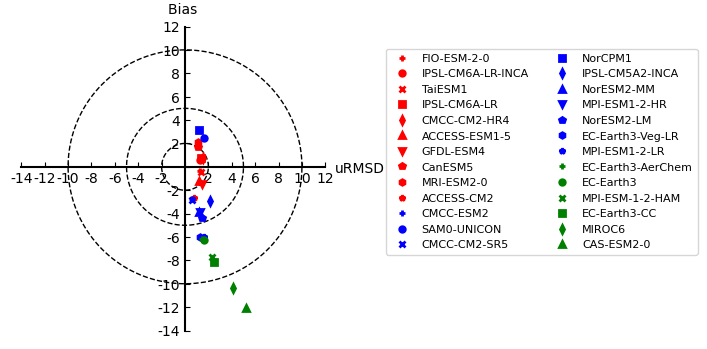

In [43]:
# 
sm.target_diagram(bias[isort],crmsd[isort],rmsd[isort], markerLabel = lsort, markerSize = 4, equalAxes='on',
                 markerLegend = 'on', MarkerDisplayed = 'marker',
                  circleLineWidth = 1, circles = [2, 5, 10], ticks = np.arange(-14,14,2), axismax=13,labelWeight=2)

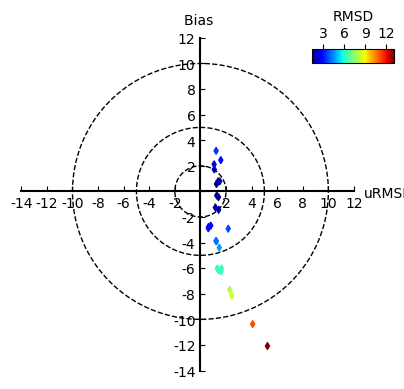

In [26]:
# 
sm.target_diagram(bias[isort],crmsd[isort],rmsd[isort], markerLabel = lsort, markerSize = 6, equalAxes='on',
                 markerLegend = 'on', MarkerDisplayed = 'colorBar',
                      titleColorbar = 'RMSD', cmapzdata = rmsd[isort], 
                  circleLineWidth = 1, circles = [2, 5, 10], ticks = np.arange(-14,14,2), axismax=13)

In [47]:
# annual means and ensembles
sieM = sie.resample('1Y').mean()
sieSTD = sie.resample('1Y').std()
osi450_sieM = osi450_sie.resample('1Y').mean()

m = sieM.mean(axis=1)
std = sieM.std(axis=1)
mbest = sieM[best8].mean(axis=1)
stdbest = sieM[best8].std(axis=1)

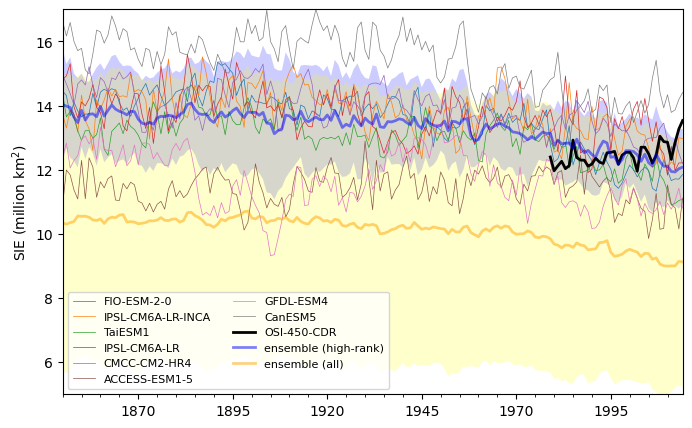

In [55]:
fig, ax = plt.subplots(1,figsize=(8,5))
sieM[best8].plot(ax=ax,linewidth=0.5)
osi450_sieM.plot(ax=ax,color='k',linewidth=2)
# best model ensemble
mbest.plot(ax=ax,color='blue',linewidth=2, alpha=0.5,label='ensemble (high-rank)')
ax.fill_between(mbest.index, mbest+stdbest, mbest-stdbest, facecolor='blue', alpha=0.2)
# all model ensemble
m.plot(ax=ax,color='orange',linewidth=2, alpha=0.5,label='ensemble (all)')
ax.fill_between(m.index, m+std, m-std, facecolor='yellow', alpha=0.2)
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=8)
ax.legend(loc='lower left', ncols = 2, fontsize=8)
ax.set_ylabel('SIE (million km$^2$)')
ax.set_xlabel('')
ax.set_ylim([5,17])
ax.xaxis.set_tick_params(labelsize=10)
plt.savefig('Fig3.png',dpi=300)